**Imports**

In [23]:
# Imports und Funktions-Imports
# Standard- und externe Bibliotheken
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

# Eigene Funktions-Module für Daten, Berechnung und Steuerung
from functions.retro_data.weather_data import get_weather
from functions.retro_data.spotprice_data import get_spotprice
from functions.retro_data.consumption_data import get_demand

from functions.forecast.spotprice_forecast_data import get_spotprice_forecast
from functions.forecast.weather_forecast_data import get_weather_forecast
from functions.forecast.weather_real_data import get_weather_real
from functions.forecast.consumption_forecast_data import get_demand_forecast

from functions.calculations.calculations import calculate_energy
from functions.calculations.kpis_valid import calculate_kpis_valid
from functions.deciding_functions.optimized import optimize_energy_flow
from functions.deciding_functions.rulebased import rule_based_energy_flow
from functions.results.results import get_results

**Definition des Green Energy Ecosystems**

In [24]:
# Systemparameter und Annahmen
# Hier werden alle relevanten Systemparameter für PV, Wind, Batterie, Verbraucher etc. gesetzt.
# Werte können für Szenarien einfach angepasst werden.

# Photovoltaik
solar_peak_power = 38  # Spitzenleistung Gesamtsystem PV [MW]
num_modules = 114980 #Anzahl Solarmodule
area_per_module = 1.57458  # Fläche pro Modul [m²] (Annahme Heckert Solar NeMo® 2.0 330 Wp)
module_efficiency = 0.196  # Wirkungsgrad der Solarmodule (Annahme Heckert Solar NeMo® 2.0 330 Wp)
tilt_angle = 45  # Neigungswinkel der Solarpanels [°] (Annahme)
latitude=51.751111 # Breitengrad
longitude=4.208611 # Längengrad
azimuth=180 # Azimut [°]
albedo=0.2 # Albedo

# Windkraft 
wind_peak_power = 22   # Spitzenleistung Gesamtsystem Windkraft [MW]
r = 60 # Rotor Radius [m]
h = 90 # Höhe Windrad [m]
turbine_efficiency = 0.5  # Wirkungsgrad der Windkraftanlagen (Annahme)
cut_in = 2.5  # Einschaltgeschwindigkeit [m/s]
cut_out = 28  # Abschaltgeschwindigkeit [m/s]
num_turbines = 6 # Anzahl Windkraftanlagen

# Batteriespeicher
battery_capacity = 12  # [MWh]
soc = 0.5  # State of Charge (SOC) initial [0-1]
initial_battery = soc * battery_capacity  # [MWh]
charging_rate = 10  # Lade-/Entladerate [MW]
discharging_rate = 10

# Verbraucher
yearly_demand = 2.7  #  Verbrauch eines Haushalts/Jahr [MWh] (Annahme)
num_houses = 39000  # Anzahl Haushalte

# Strompreis
export_factor = 0.25   # Anteil vom Spotpreis für Einspeisung
price_low_quant  = 0.30   # Regelbasiert: Niedrigpreis-Schwelle

# Parameter für Sliding Window
forecast_horizon = 48   # Länge des Fensters [Tage] (2)
stepsize = 1    # Schrittweite [Stunden] (1)

**Vorbereiten der Datensätze**

In [25]:
df_weather_forecast = get_weather_forecast()
df_weather_real = get_weather_real()
df_spot_forecast, df_spot_real = get_spotprice_forecast()
df_demand_real = get_demand_forecast(num_houses, yearly_demand)

c:\Users\Julian\Documents\01_Hochschule\Master\02_Semester\Forschungsseminar\Code\functions\forecast\spotprice_forecast_data.py:13: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dt_local_naive = pd.to_datetime(


**Ausführen der Berechnungsfunktion**

In [26]:
# Energie- und Bedarfsberechnung für Trainings- und Testdaten
# Berechnet PV-/Wind-Ertrag und merged alle relevanten Spalten.

df_energy_forecast = calculate_energy(
    df_weather_forecast, 
    solar_peak_power, num_modules, area_per_module, module_efficiency, tilt_angle, latitude, longitude, azimuth, albedo, 
    wind_peak_power, r, h, turbine_efficiency, cut_in, cut_out, num_turbines
)

df_forecast = df_energy_forecast.merge(
    df_spot_forecast[['datetime', 'spotprice']],
    on='datetime', how='left'
 ).merge(
    df_demand_real[['datetime', 'energy_demand']],
    on='datetime', how='left'
 ).reset_index(drop=True)

df_energy_real = calculate_energy(
    df_weather_real, 
    solar_peak_power, num_modules, area_per_module, module_efficiency, tilt_angle, latitude, longitude, azimuth, albedo, 
    wind_peak_power, r, h, turbine_efficiency, cut_in, cut_out, num_turbines
)

df_real = df_energy_real.merge(
    df_spot_real[['datetime', 'spotprice']],
    on='datetime', how='left'
 ).merge(
    df_demand_real[['datetime', 'energy_demand']],
    on='datetime', how='left'
 ).reset_index(drop=True)

# Optional: Daten anzeigen
# display(df_train.head()), display(df_test.head())

**Ausführen der Entscheidungs-Funktionen**

In [27]:
# Regelbasierte Steuerung (Testdaten)
# Einfache Heuristik für Batterie- und Netzmanagement.

result_df_rule_forecast = rule_based_energy_flow(
    df_forecast, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, price_low_quant
    )

result_df_rule_real = rule_based_energy_flow(
    df_real, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, price_low_quant
    )

result_kpis_rule_forecast = calculate_kpis_valid(result_df_rule_forecast, df_spot_real, export_factor)
result_kpis_rule_real = calculate_kpis_valid(result_df_rule_real, df_spot_real, export_factor)

In [28]:
forecast_horizon = 1

result_df_opt_noforecast = optimize_energy_flow(
    df_real, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, 
    forecast_horizon, stepsize
    )

#Proforma
result = optimize_energy_flow(
    df_real, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, 
    forecast_horizon, stepsize
    )

result_kpis_opt_noforecast = calculate_kpis_valid(result_df_opt_noforecast, df_spot_real, export_factor)
result_kpis = calculate_kpis_valid(result, df_spot_real, export_factor)

In [29]:
forecast_horizon = 48

result_df_opt_forecast = optimize_energy_flow(
    df_forecast, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, 
    forecast_horizon, stepsize
    )

result_df_opt_real = optimize_energy_flow(
    df_real, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, 
    forecast_horizon, stepsize
    )

result_kpis_opt_forecast = calculate_kpis_valid(result_df_opt_forecast, df_spot_real, export_factor)
result_kpis_opt_real = calculate_kpis_valid(result_df_opt_real, df_spot_real, export_factor)

Ergebnisse mit Echzeitdaten

Regelbasiert:
Netto Stromkosten: 4442.10 €
Netzstromkosten: 4619.94 €
Einspeisevergütung: 177.84 €
Export-gewichteter Preis (rule): 6.14 €/MWh
Netzbezug: 494.30 MWh
Einspeisung: 115.91 MWh
Batterieladung: 70.12 MWh
Batterieentladung: 76.12 MWh
----------------------
Optimiert (ohne Prognose):
Netto Stromkosten: 4532.56 €
Netzstromkosten: 4739.84 €
Einspeisevergütung: 207.28 €
Export-gewichteter Preis (opt):  5.71 €/MWh
Netzbezug: 512.30 MWh
Einspeisung: 145.30 MWh
Batterieladung: 0.00 MWh
Batterieentladung: 6.00 MWh
----------------------
Optimiert (mit Prognose):
Netto Stromkosten: 3992.14 €
Netzstromkosten: 4147.60 €
Einspeisevergütung: 155.46 €
Export-gewichteter Preis (RL):  6.55 €/MWh
Netzbezug: 461.95 MWh
Einspeisung: 94.95 MWh
Batterieladung: 82.59 MWh
Batterieentladung: 88.59 MWh
----------------------


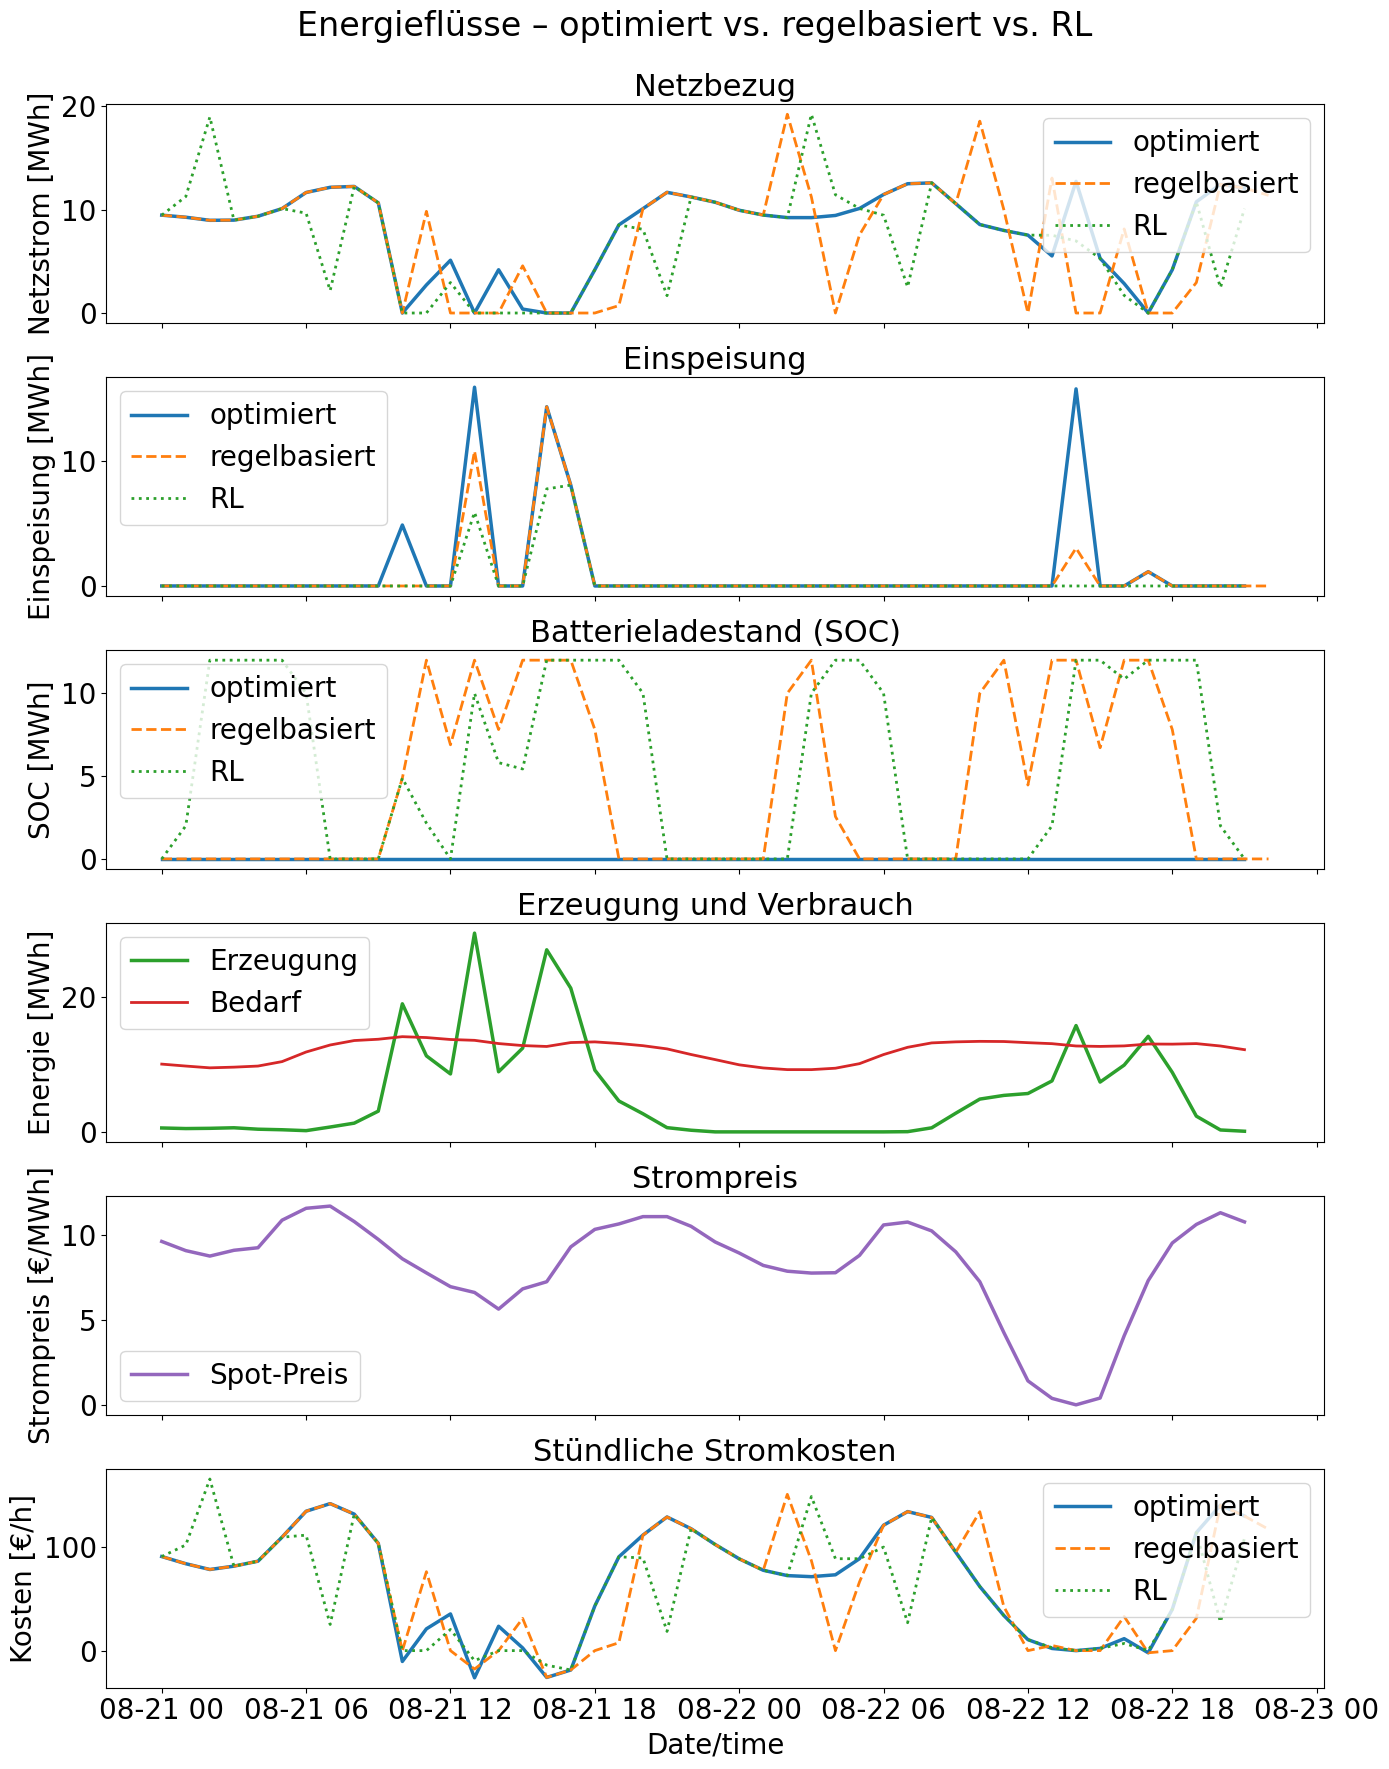

In [30]:
df_real = get_results(result_df_rule_real, result_df_opt_noforecast, result_df_opt_real, result_kpis_rule_real, result_kpis_opt_noforecast, result_kpis_opt_real, export_factor)

Ergebnisse mit Prognose 
->mittleres missachten

Regelbasiert:
Netto Stromkosten: 3508.81 €
Netzstromkosten: 3809.82 €
Einspeisevergütung: 301.01 €
Export-gewichteter Preis (rule): 5.06 €/MWh
Netzbezug: 399.98 MWh
Einspeisung: 201.56 MWh
Batterieladung: 89.69 MWh
Batterieentladung: 95.69 MWh
----------------------
Optimiert (ohne Prognose):
Netto Stromkosten: 4532.56 €
Netzstromkosten: 4739.84 €
Einspeisevergütung: 207.28 €
Export-gewichteter Preis (opt):  5.71 €/MWh
Netzbezug: 512.30 MWh
Einspeisung: 145.30 MWh
Batterieladung: 0.00 MWh
Batterieentladung: 6.00 MWh
----------------------
Optimiert (mit Prognose):
Netto Stromkosten: 3366.69 €
Netzstromkosten: 3657.25 €
Einspeisevergütung: 290.57 €
Export-gewichteter Preis (RL):  5.18 €/MWh
Netzbezug: 378.59 MWh
Einspeisung: 191.56 MWh
Batterieladung: 96.59 MWh
Batterieentladung: 102.59 MWh
----------------------


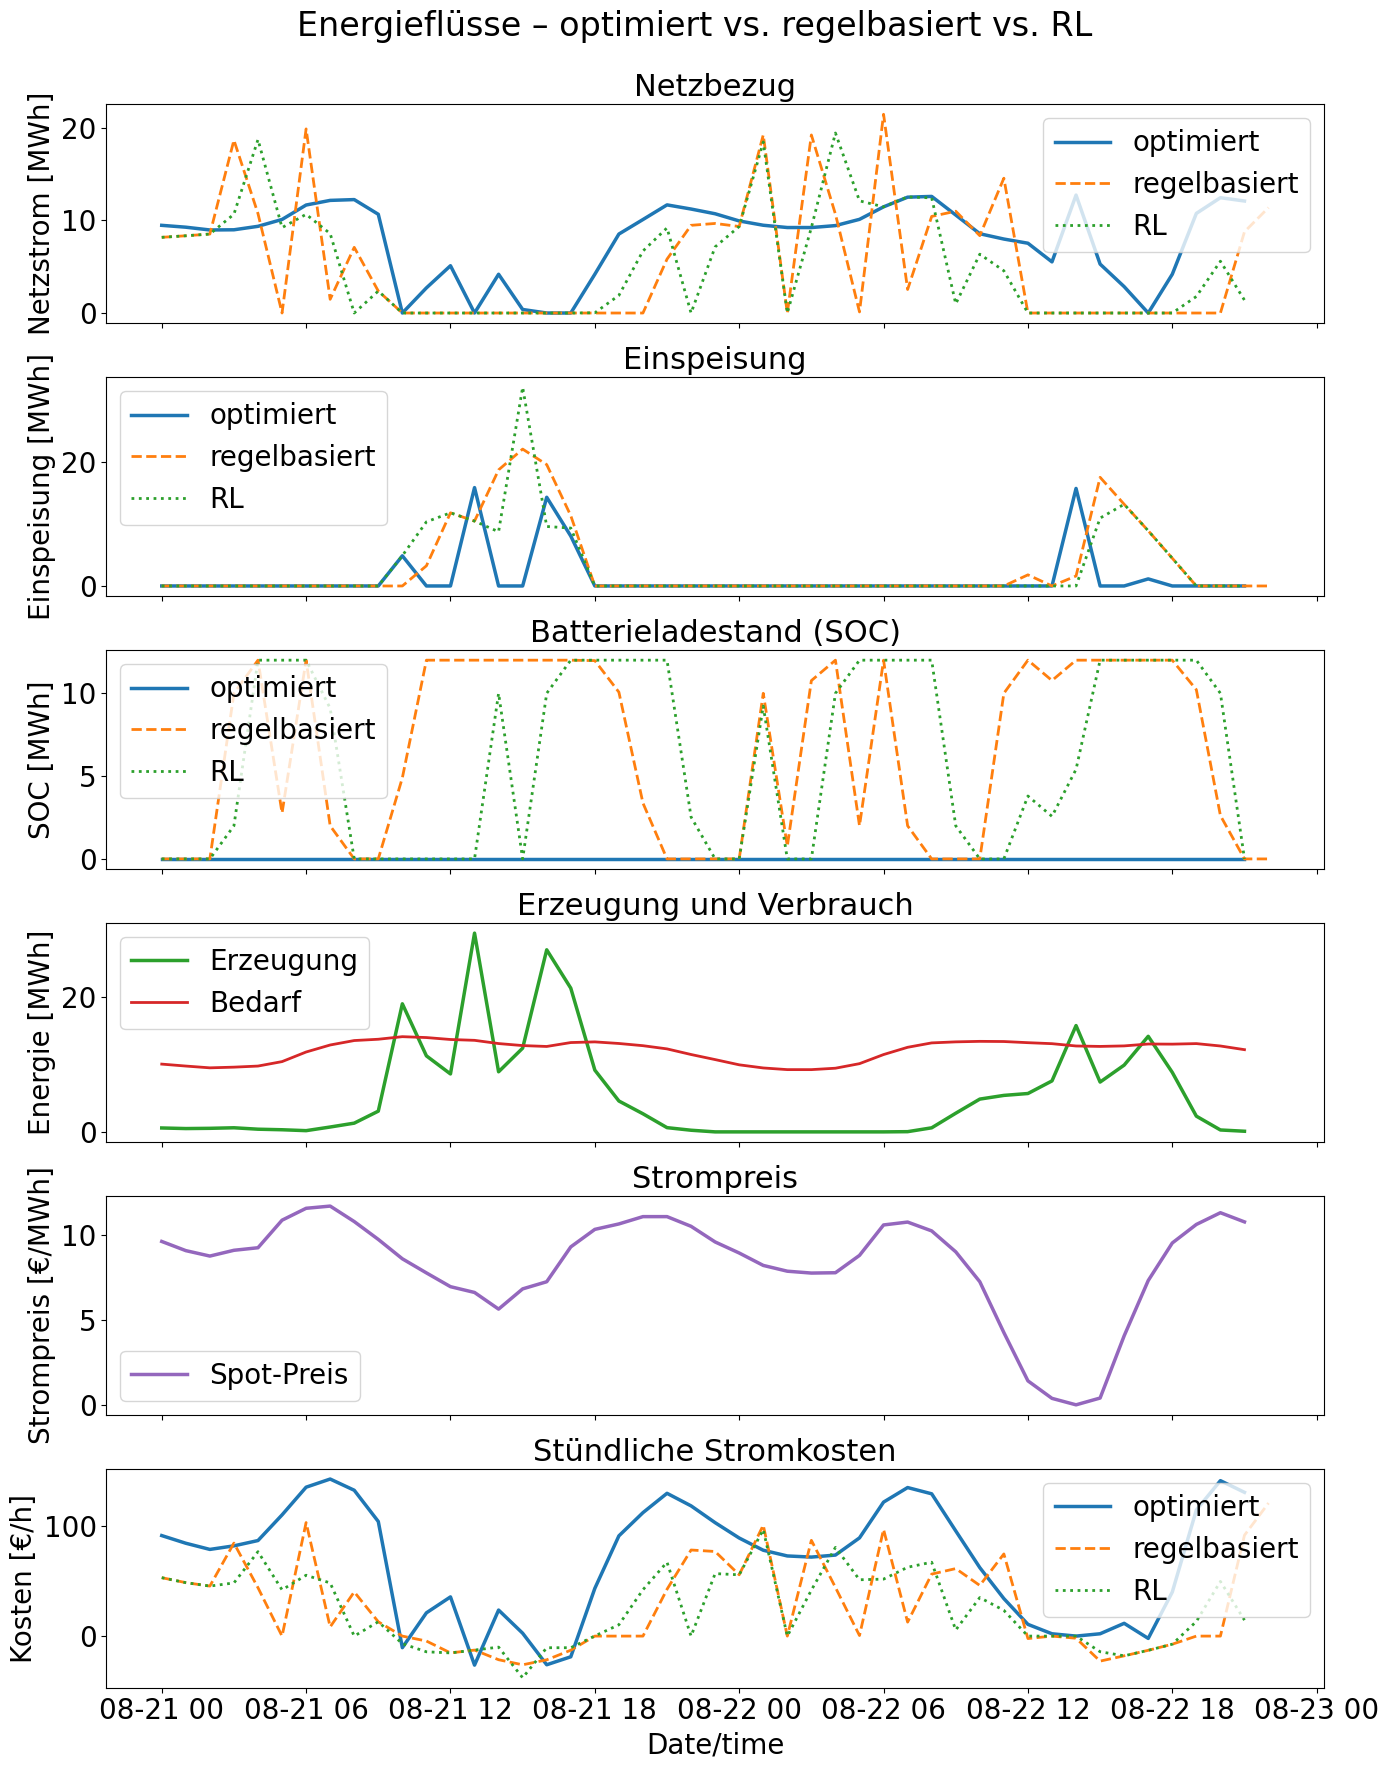

In [31]:
df_forecast = get_results(result_df_rule_forecast, result_df_opt_noforecast, result_df_opt_forecast, result_kpis_rule_forecast, result_kpis_opt_noforecast, result_kpis_opt_forecast, export_factor)

In [32]:
df_forecast.to_csv("df_forecast.csv", index=False)
df_real.to_csv("df_real.csv", index=False)

AttributeError: 'NoneType' object has no attribute 'to_csv'